# Metody Obliczeniowe w Nauce i Technice
# Laboratorium 2: Rozwiązywanie układów równań liniowych
## Przemysław Roman

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy

def time_exec(func, *args):
    start_time = time.time()
    result = func(*args)
    return result, time.time() - start_time

## Zadanie 1 Metoda Gaussa-Jordana

Napisz i sprawdź funkcję rozwiązującą układ równań liniowych n × n metodą Gaussa-
Jordana. Dla rozmiarów macierzy współczynników większych niż 500 × 500 porównaj
czasy działania zaimplementowanej funkcji z czasami uzyskanymi dla wybranych funkcji
bibliotecznych.

Funkcje pomocnicze

In [67]:
# układa rzędy tak aby ilość wiodących zer w rzędach była niemalejąca idąc od góry do dołu układu równań
def order_rows_by_leading_zeros(AB, n):
  pre_zeros = [0] * n

  for i in range(n):
    for j in range(n):
      if AB[i,j] != 0:
        break
      pre_zeros[i] += 1

  sorted_indexes = [i for _, i in sorted(zip(pre_zeros, range(n)))]
  return np.array([AB[i] for i in sorted_indexes])

# sprawia, że wszystkie elementy w tablicy są w zakresie [0, 1]
def scaling(AB, n):
    for i in range(n):
        _max = max(AB[i])
        AB[i] /= np.max(AB[i])

Implementacja algorytmu Gaussa-Jordana z wykorzystaniem partial pivotingu

In [68]:
def find_max_abs_scalar_in_col(AB, n, col):
    i = col + 1
    if i < n:
        return i + np.absolute(AB[i:,col]).argmax()
    return -1

# i - rząd, j - kolumna
def gauss_jordan_partial_pivoting(_AB, inplace=False):
    n = _AB.shape[0]
    if inplace:
        AB = _AB
    else:
        AB = deepcopy(_AB) # żeby nie niszczyć macierzy wejściowej
    AB = order_rows_by_leading_zeros(AB, n)
    scaling(AB, n)

    for i in range(n):
        # partial pivoting
        max_i = find_max_abs_scalar_in_col(AB, n, i)
        if max_i != -1:
            AB[[i,max_i]] = AB[[max_i,i]]

        if AB[i,i] != 0:
            # redukcja pivotu do 1
            scalar = 1 / AB[i,i]
            AB[i] *= scalar

            # redukcja współczynników do 0, które znajdują się w tej samej kolumnie co pivot
            for k in range(n):
                if k != i:
                    scalar = AB[k,i] / AB[i,i]
                    AB[k] -= scalar * AB[i]

    return AB[:,-1] # ostatnia kolumna zawiera wyniki

Implementacja algorytmu Gaussa-Jordana z wykorzystaniem full pivotingu

In [69]:
def find_max_abs_scalar_in_box(AB, n, box_i):
    i = j = box_i + 1
    if i < n:
        max_i, max_j = np.unravel_index(np.absolute(AB[i:,j:n]).argmax(), [n-i,n-j])
        return i + max_i, j + max_j
    return -1, -1

# i - rząd, j - kolumna
def gauss_jordan_full_pivoting(_AB, inplace=False):
    n = _AB.shape[0]
    if inplace:
        AB = _AB
    else:
        AB = deepcopy(_AB) # żeby nie niszczyć macierzy wejściowej
    AB = order_rows_by_leading_zeros(AB, n)
    scaling(AB, n)

    variables_permutations = []
    for i in range(n):
        # full pivoting
        max_i, max_j = find_max_abs_scalar_in_box(AB, n, i)
        if max_i != -1:
            AB[[i,max_i]] = AB[[max_i,i]]
            AB[:,[i,max_j]] = AB[:,[max_j,i]]
            variables_permutations.append((i, max_j))

        if AB[i,i] != 0:
            # redukcja pivotu do 1
            scalar = 1 / AB[i,i]
            AB[i] *= scalar

            # redukcja współczynników do 0, które znajdują się w tej samej kolumnie co pivot
            for k in range(n):
                if k != i:
                    scalar = AB[k,i] / AB[i,i]
                    AB[k] -= scalar * AB[i]

    B = AB[:,-1] # ostatnia kolumna zawiera wyniki
    # należy przywrócić zmienne do początkowej kolejności (zaburzono ją zamieniając kolumny)
    for v1, v2 in reversed(variables_permutations):
        B[v1], B[v2] = B[v2], B[v1]

    return B

Testy poprawności rozwiązania oraz czasu wykonania

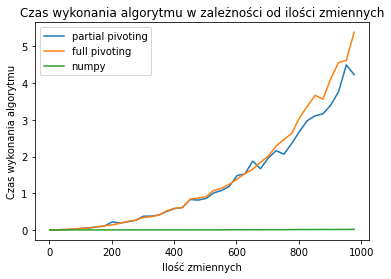

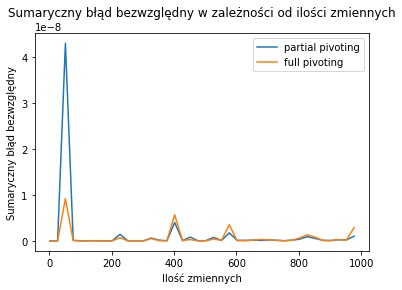

Czas wykonania testera: 111.53826522827148[s]


In [70]:
def get_absolute_errors_sum(vals, expected_vals):
    return np.sum(np.absolute(vals - expected_vals))

def gauss_jordan_tester_iter(tnps, tpps, tfps, pp_errors, fp_errors, n):
    A = np.random.random((n, n))
    B = np.random.random((n, 1))
    AB = np.concatenate((A, B), axis=1)

    Xnp, tnp = time_exec(np.linalg.solve, A, B)
    Xnp = Xnp.flatten()
    tnps.append(tnp)

    Xpp, tpp = time_exec(gauss_jordan_partial_pivoting, AB)
    pp_error = get_absolute_errors_sum(Xpp, Xnp)
    pp_errors.append(pp_error)
    tpps.append(tpp)

    Xfp, tfp = time_exec(gauss_jordan_full_pivoting, AB)
    fp_error = get_absolute_errors_sum(Xfp, Xnp)
    fp_errors.append(fp_error)
    tfps.append(tfp)

def gauss_jordan_tester_plot(tnps, tpps, tfps, pp_errors, fp_errors, ns):
    plt.plot(ns, tpps, label='partial pivoting')
    plt.plot(ns, tfps, label='full pivoting')
    plt.plot(ns, tnps, label='numpy')
    plt.xlabel('Ilość zmiennych')
    plt.ylabel('Czas wykonania algorytmu')
    plt.title('Czas wykonania algorytmu w zależności od ilości zmiennych')
    plt.legend()
    plt.show()

    plt.plot(ns, pp_errors, label='partial pivoting')
    plt.plot(ns, fp_errors, label='full pivoting')
    plt.xlabel('Ilość zmiennych')
    plt.ylabel('Sumaryczny błąd bezwzględny')
    plt.title('Sumaryczny błąd bezwzględny w zależności od ilości zmiennych', y=1.05)
    plt.legend()
    plt.show()

def gauss_jordan_tester(N, step, seed=11792):
    np.random.seed(seed)
    pp_errors = []; fp_errors = []
    tnps = []; tpps = []; tfps = []
    ns = list(range(2, N, step))

    for n in ns:
        gauss_jordan_tester_iter(tnps, tpps, tfps, pp_errors, fp_errors, n)

    gauss_jordan_tester_plot(tnps, tpps, tfps, pp_errors, fp_errors, ns)

r, t = time_exec(gauss_jordan_tester, 1000, 25)
print(f'Czas wykonania testera: {t}[s]')

Partial pivoting i full pivoting wykonują się w podobnym czasie, dokładność rozwiązań jest również podobna.
Czas wykonania moich implementacji rośnie znacznie szybciej niż solver z biblioteki numpy (wraz ze wzrostem ilości zmiennych).
Wyniki są całkiem dokładne (dokładność rzędu $ 10^{-8} $ dla wybranego seedu). Na wykresie przedstawiającym zależność błędu od ilości zmiennych
sporadycznie występują ostre szpice, które powstają przypadkowo.

## Zadanie 2 Faktoryzacja LU

Napisz i przetestuj funkcję dokonującą faktoryzacji $ \textbf{A = LU} $ macierzy $ \textbf{A} $ (bez poszuki-
wania elementu wiodącego). Sprawdź poprawność wyniku obliczając $ \textbf{||A − LU||} $. Zadbaj
o to żeby implementacja była in-situ. Elementy macierzy $ \textbf{L} $ to współczynniki mnożenia
umożliwiające wyzerowanie odpowiedniego współczynnika macierzy $ \textbf{A} $ w trakcie procesu
eliminacji.

Implementacja algorytmu faktoryzacji LU macierzy

In [71]:
def factorize_matrix(A, inplace=False):
    n = A.shape[0]
    if inplace:
        LU = A
    else:
        LU = deepcopy(A) # żeby nie niszczyć macierzy wejściowej
    LU = order_rows_by_leading_zeros(LU, n)

    for i in range(n):
        if LU[i,i] != 0:
            for k in range(i+1, n):
                if k != i:
                    scalar = LU[k,i] / LU[i,i]
                    LU[k] -= scalar * LU[i]
                    LU[k,i] = scalar

    return LU

def split_LU(LU):
    n = LU.shape[0]
    L = deepcopy(LU)
    U = deepcopy(LU)
    for i in range(n):
        L[i,i] = 1
        for j in range(i+1, n):
            L[i,j] = 0
            U[j,i] = 0

    return L, U

Testy poprawności rozwiązania oraz czasu wykonania

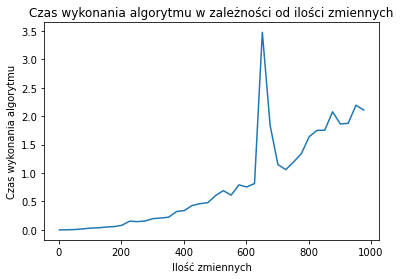

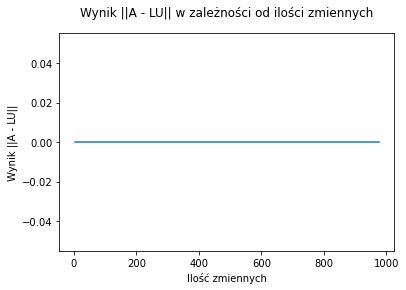

Czas wykonania testera: 36.1387403011322[s]


In [72]:
def get_matrix_factorization_error(A, L, U):
    return np.linalg.det(A - np.matmul(L, U))

def matrix_factorization_tester_plot(ts, errors, ns):
    plt.plot(ns, ts)
    plt.xlabel('Ilość zmiennych')
    plt.ylabel('Czas wykonania algorytmu')
    plt.title('Czas wykonania algorytmu w zależności od ilości zmiennych')
    plt.show()

    plt.plot(ns, errors)
    plt.xlabel('Ilość zmiennych')
    plt.ylabel('Wynik ||A - LU||')
    plt.title('Wynik ||A - LU|| w zależności od ilości zmiennych', y=1.05)
    plt.show()

def matrix_factorization_tester(N, step, seed=11792):
    np.random.seed(seed)
    ts = []; errors = []
    ns = list(range(2, N, step))

    for n in ns:
        A = np.random.random((n, n))
        LU, t = time_exec(factorize_matrix, A)
        L, U = split_LU(LU)
        ts.append(t)
        errors.append(get_matrix_factorization_error(A, L, U))

    matrix_factorization_tester_plot(ts, errors, ns)

r, t = time_exec(matrix_factorization_tester, 1000, 25)
print(f'Czas wykonania testera: {t}[s]')

Faktoryzacja jest bardzo dokładna, dla wszystkich testowanych ilości zmiennych wynik $ ||A − LU|| = 0 $, co jest oczekiwanym wynikiem.

## Zadanie 3 Analiza obwodu elektrycznego - nadokreślony układ równań

Napisz program, który:
a) Wczytuje z pliku listę krawędzi grafu nieskierowanego ważonego opisującego ob-
wód elektryczny. Wagi krawędzi określają opór fragmentu obwodu między dwoma
węzłami. Wierzchołki grafu identyfikowane są przez liczby naturalne.
b) Wczytuje dodatkowo trójkę liczb (s, t, E), przy czym para (s, t) wskazuje mię-
dzy którymi węzłami sieci przyłożono siłę elektromotoryczną E. Opór wewnętrzny
SEM można zaniedbać.
c) Wykorzystując prawa Kirchhoffa (albo metodę potencjałów węzłowych) znajduje
natężenia prądu w każdej części obwodu i przedstawia je na rysunku w postaci
grafu ważonego z etykietami (wizualizacja grafu wraz z kolorowymi krawędziami
pokazującymi wartość natężenia prądu oraz jego kierunek)
d) Przedstaw (wizualizacja + automatyczne sprawdzenie poprawności wyników) dzia-
łanie programu dla grafów spójnych mających od 15 do 200 wierzchołków. Rozważ
następujące typy grafów:
– Spójny graf losowy (Erdős-Rényi)
– Graf 3-regularny (kubiczny)
– Graf złożony z dwóch grafów losowych połaczonych mostkiem
– Graf siatka 2D
– Graf typu small-world
e) Skomentuj wybrane rozwiązanie - prawa Kirchoffa I, II vs. metoda potencjałów
węzłowych. W przypadku korzystania z praw Kirchoffa - w jaki sposób możemy
rozwiązać nadokreślony układ równań. Opisz najważniejsze aspekty swojego roz-
wiązania (kierunek prądu, weryfikacja poprawności rozwiązania, sposób wyznacza-
nia cykli prostych).

Program znajduje się w oddzielnym pliku *electrical_circuit_model.py*, poniżej zademonstrowano jego działanie.
Program uruchamia się z wiersza poleceń, znajdując się w tym samym katalogu co program należy wpisać:
``python electrical_circuit_model.py <edgelist_file> <s> <t> <E>``, gdzie:
- edgelist_file jest ścieżką do pliku, który zawiera reprezentację grafu,
- s, t to wierzchołki pomiędzy którymi przyłożono SEM E.

Reprezentacja grafu powinna być następująca:
```
0 4 {'R': 30.480627303287523}
0 1 {'R': 19.506726650825932}
<node_from> <node_to> {'R': <resistance_value>}
...
```

Do generowania grafów można użyć programu *graph_generator.py*. Uruchamia się go z wiersza poleceń analogicznie jak program główny:
``python graph_generator.py <seed>``, gdzie seed jest oczywistym argumentem (generowanie jest pseudolosowe).

### Demonstracja działania programu

In [1]:
import electrical_circuit_model as ecm
import graph_generator as gg
import networkx as nx

GG = gg.GraphGenerator(seed=7129)

#### Małe testy
Testy mające małą ilość węzłów, żeby zachować czytelność

Spójny graf losowy (Erdős-Rényi)

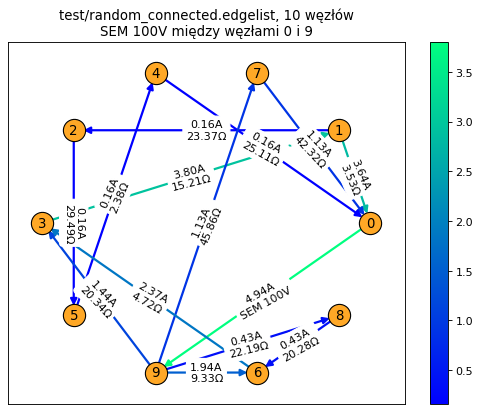

In [3]:
n = 10
G, edgelist_file = GG.generate_graph_random_connected(n, 0.1)
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, n-1, 100)
ECM.simulate()
ECM.display(layout=nx.circular_layout)

Graf 3-regularny (kubiczny)

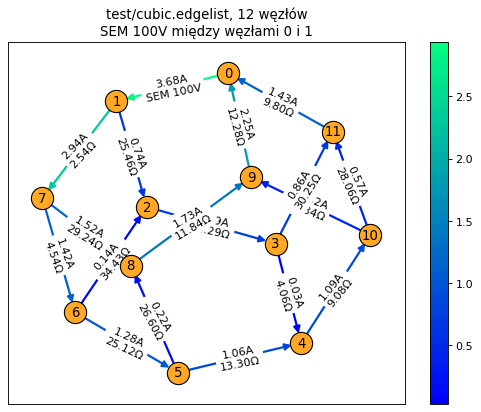

In [4]:
G, edgelist_file = GG.generate_graph_cubic()
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, 1, 100)
ECM.simulate()
ECM.display(layout=nx.kamada_kawai_layout)

Graf złożony z dwóch grafów losowych połaczonych mostkiem

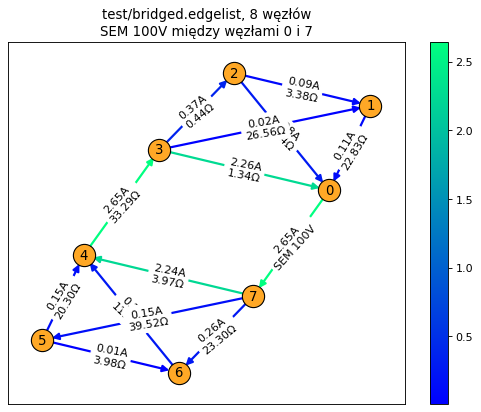

In [5]:
n = 4
G, edgelist_file = GG.generate_graph_bridged(n, 0)
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, 2*n-1, 100)
ECM.simulate()
ECM.display(layout=nx.kamada_kawai_layout)

Graf siatka 2D

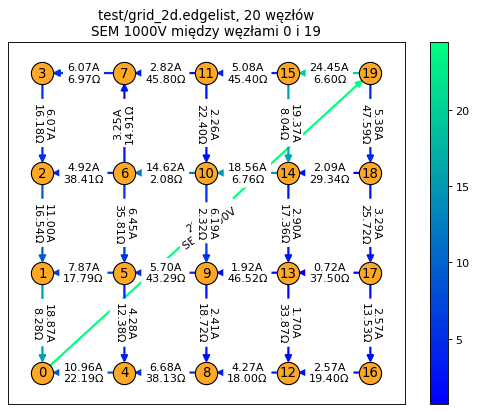

In [6]:
m = 5
n = 4
G, edgelist_file = GG.generate_graph_grid_2d(m, n)
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, m*n-1, 1000)
pos = {i: (i//n, i%n) for i in range(m*n)}
ECM.simulate()
ECM.display(pos=pos)

Graf typu small-world

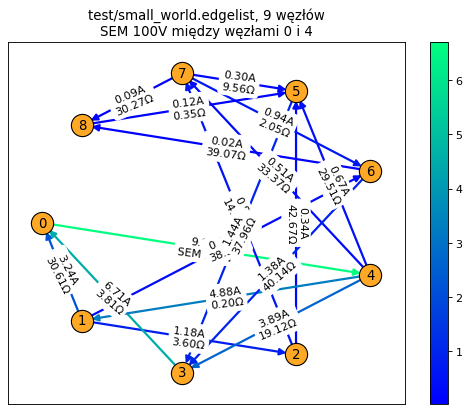

In [7]:
n = 3
G, edgelist_file = GG.generate_graph_small_world(n)
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, n**2//2, 100)
ECM.simulate()
ECM.display(layout=nx.shell_layout)

#### Większe testy
Testy mające większą ilość węzłów kosztem czytelności

Spójny graf losowy (Erdős-Rényi)

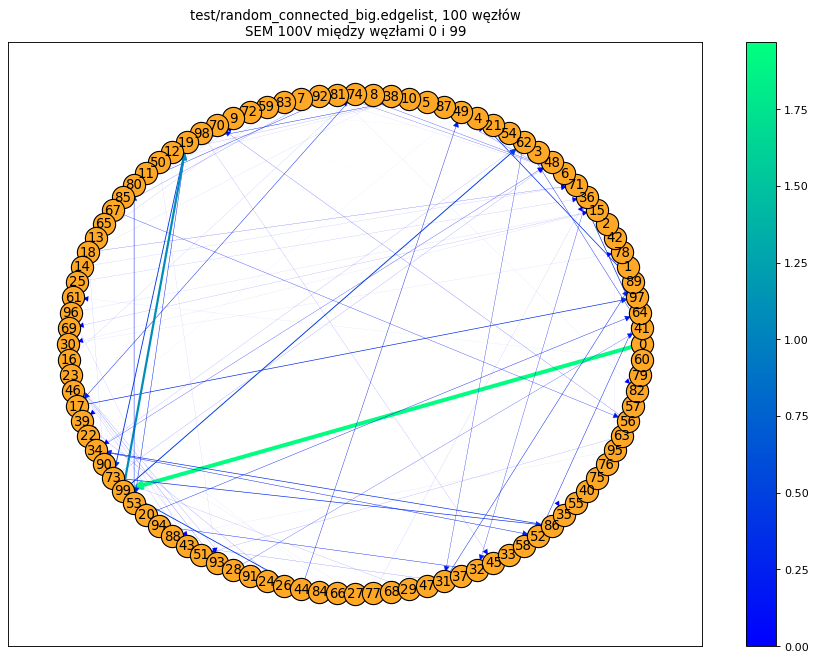

In [4]:
n = 75
G, edgelist_file = GG.generate_graph_random_connected(n, 0.2, save_file_path='random_connected_big.edgelist')
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, n-1, 1000)
ECM.simulate()
ECM.display(layout=nx.circular_layout, scale=0.4, show_amperage_labels=False)

Graf 3-regularny (kubiczny)

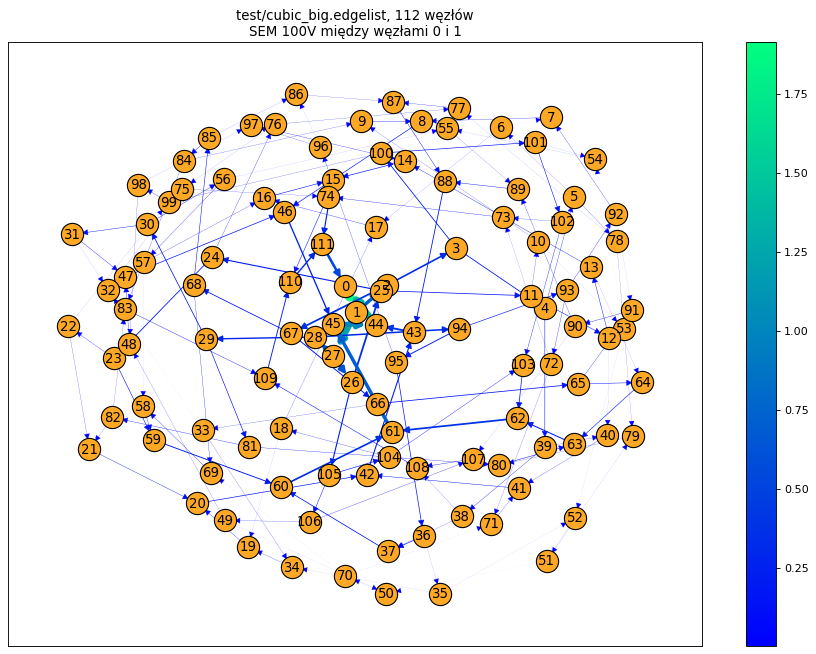

In [8]:
G, edgelist_file = GG.generate_graph_cubic(graph_id=4, save_file_path='cubic_big.edgelist')
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, 1, 100)
ECM.simulate()
ECM.display(layout=nx.kamada_kawai_layout, scale=0.5, show_amperage_labels=False)

Graf złożony z dwóch grafów losowych połaczonych mostkiem

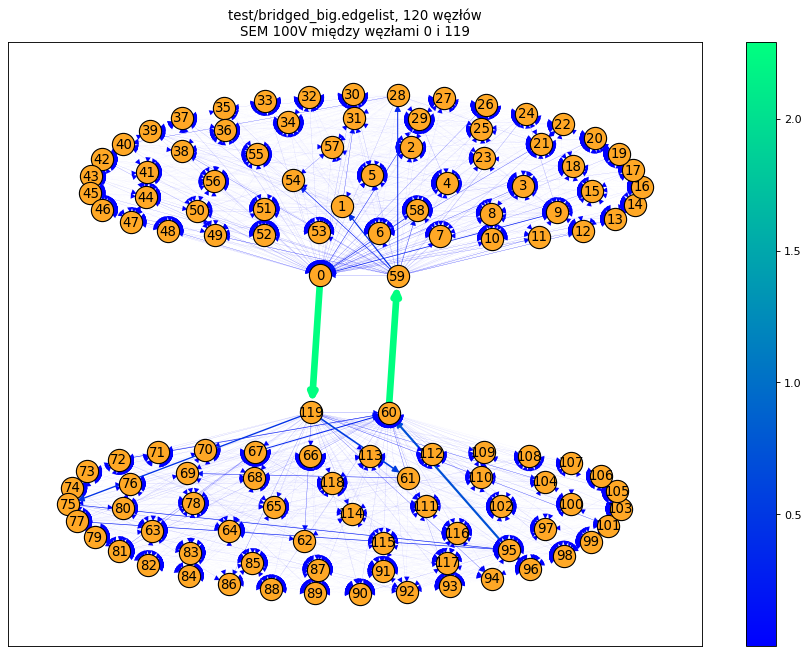

In [12]:
n = 60
G, edgelist_file = GG.generate_graph_bridged(n, 0, save_file_path='bridged_big.edgelist')
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, 2*n-1, 100)
ECM.simulate()
ECM.display(layout=nx.kamada_kawai_layout, scale=0.5, show_amperage_labels=False)

Graf siatka 2D

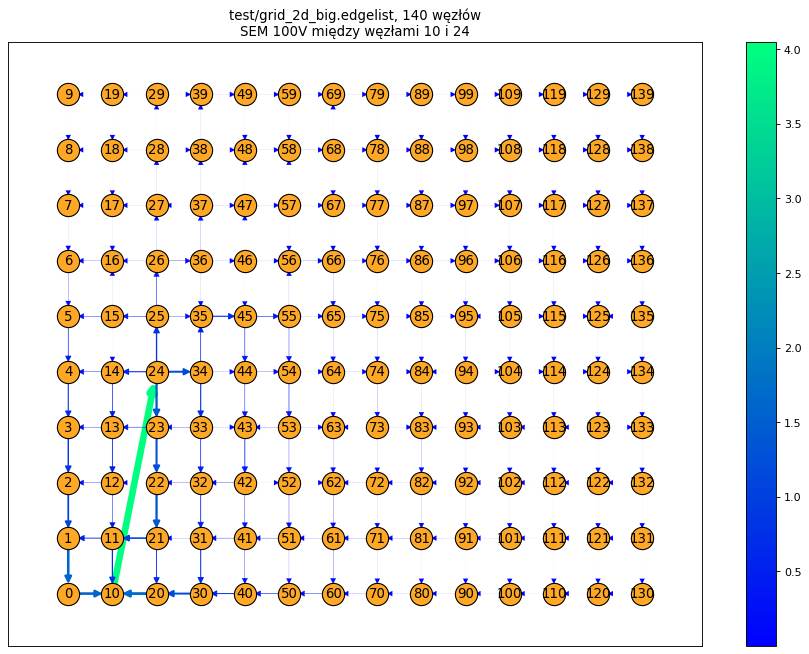

In [15]:
m = 20
n = 10
G, edgelist_file = GG.generate_graph_grid_2d(m, n, save_file_path='grid_2d_big.edgelist')
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, m*n-1, 1000)
pos = {i: (i//n, i%n) for i in range(m*n)}
ECM.simulate()
ECM.display(pos=pos, scale=0.3, show_amperage_labels=False)

Graf typu small-world

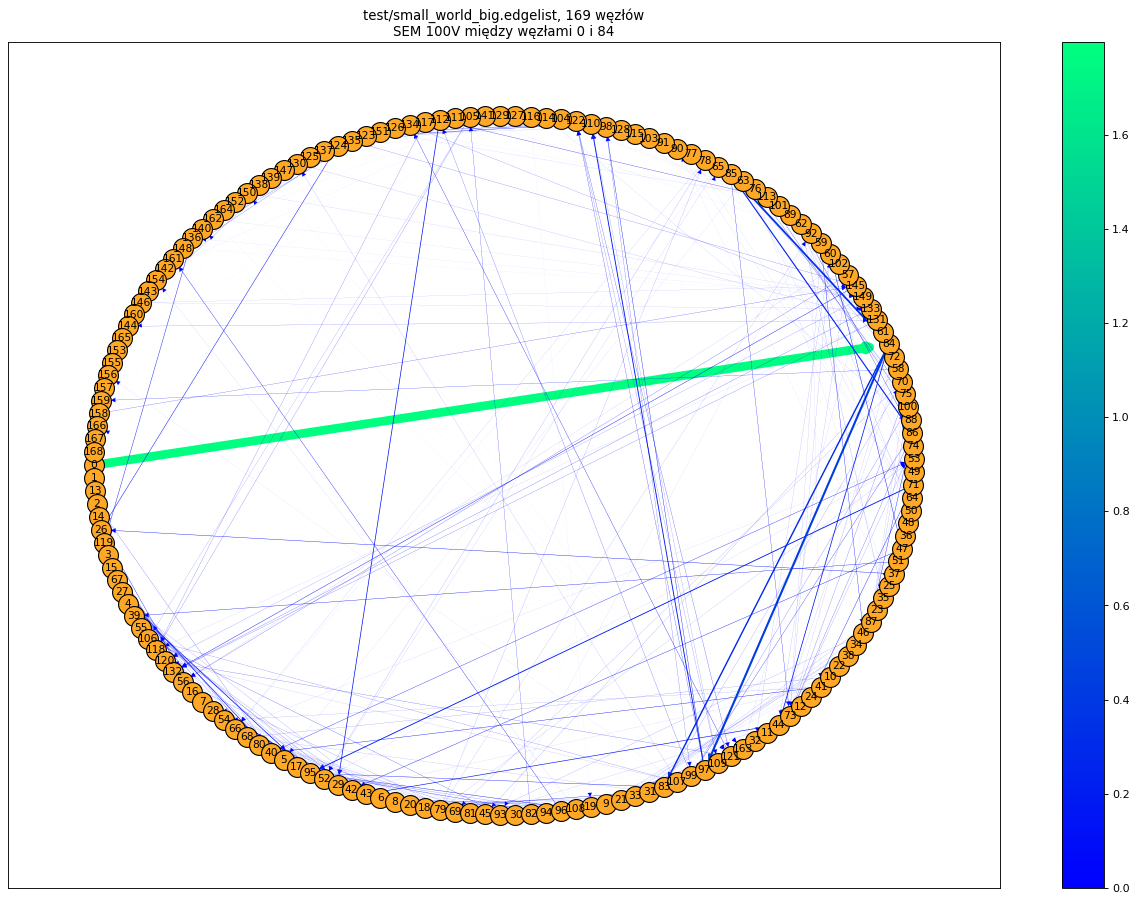

In [22]:
n = 15
G, edgelist_file = GG.generate_graph_small_world(n, save_file_path='small_world_big.edgelist')
ECM = ecm.ElectricalCircuitModel(edgelist_file, 0, n**2//2, 100)
ECM.simulate()
ECM.display(layout=nx.shell_layout, scale=0.3, show_amperage_labels=False)